**Name: Nidhi Rajkumar Saini**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, silhouette_samples, silhouette_score
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

In [2]:
best_params = {}
train_error = {}
test_error = {}
test_pred = {}
test_f1score = {}
Metrics = pd.DataFrame(columns = ['Best params', 'Train Error', 'Test Error', 'F1-score'])
multi_label_eval = pd.DataFrame(columns = ['Exact Match Ratio', 'Hamming Loss'])

In [3]:
def getModel(name, c, g):
    model = SVC()
    if name == 'linear':
        model = LinearSVC(penalty = 'l1', dual = False, C = c, max_iter = 30000)
    else:
        model = SVC(C = c, kernel = 'rbf', gamma = g, decision_function_shape='ovr')
    return model

In [4]:
def SVC_CV(model, trainX, trainY):
    
    # to move the midpoint of a colormap to be around the values of interest.
    class MidpointNormalize(Normalize):

        def __init__(self, vmin = None, vmax = None, midpoint = None, clip = False):
            self.midpoint = midpoint
            Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))

    # Train classifier
    C_range = np.logspace(-2, 10, 13)
    gamma_range = np.logspace(-9, 3, 13)
    if("Linear" in str(type(model))):
        param_grid = dict(C = C_range)
    else:
        param_grid = dict(C = C_range, gamma = gamma_range)
    cv = StratifiedShuffleSplit(n_splits = 10, random_state = 42)
    grid = GridSearchCV(model, param_grid = param_grid, cv = cv, verbose = 1)
    grid.fit(trainX, trainY)
    
    print("Grid scores on development set:\n")
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    print("\nThe best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

    if("Linear" not in str(type(model))):
        scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

        # Draw heatmap of the validation accuracy for C vs gamma
        plt.figure(figsize = (8, 6))
        plt.subplots_adjust(left = .2, right = 0.95, bottom = 0.15, top = 0.95)
        plt.imshow(scores, interpolation = 'nearest', cmap = plt.cm.hot, norm = MidpointNormalize(vmin = 0.2, midpoint = 0.92))
        plt.xlabel('gamma')
        plt.ylabel('C')
        plt.colorbar()
        plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
        plt.yticks(np.arange(len(C_range)), C_range)
        plt.title('Validation accuracy')
        plt.show()
    
    return grid.best_params_

In [5]:
def compute_metrics(clf, X, Y):
    # evaluation on single-label task
    pred = clf.predict(X)
    error = 1 - clf.score(X, Y)
    f1score = f1_score(Y, pred, average = 'macro')
    print("Accuracy = ", clf.score(X, Y))
    print("\nF1-score = ", f1score)
    print("\nError = ", error)
    print("\nConfusion Matrix:\n", confusion_matrix(Y, pred))
    print("\nClassification Report:\n", classification_report(Y, pred))
    return pred, error, f1score

In [6]:
def runSVC(modeltype, label, X_train, Y_train, X_test, Y_test):
    # training classifier with default C and gamma parameters
    clf = getModel(modeltype, 1.0, 'scale')
    best_params[label] = SVC_CV(clf, X_train, Y_train[label])
    # training classifier with best C and gamma parameters
    if(modeltype != 'linear'):
        clfnew = getModel(modeltype, best_params[label]['C'], best_params[label]['gamma'])
    else:
        clfnew = getModel(modeltype, best_params[label]['C'], 'na')
    clfnew.fit(X_train, Y_train[label])
    # evaluation and train and test metrics
    print("\nTrain Metrics:\n")
    train_pred, train_error[label], train_f1score = compute_metrics(clfnew, X_train, Y_train[label])
    print("Test Metrics:\n")
    test_pred[label], test_error[label], test_f1score[label] = compute_metrics(clfnew, X_test, Y_test[label])

In [7]:
def evaluate_multiclass(y_true, y_pred):
    n = len(y_true)
    exact_match_count = np.sum(np.all(np.asarray(y_true) == np.asarray(pd.DataFrame.from_dict(y_pred)), axis = 1))
    emr = exact_match_count/n  
    hl_num = np.sum(np.sum(y_true != pd.DataFrame.from_dict(y_pred)))
    hl_den = np.prod(y_true.shape)
    hl = hl_num/hl_den
    return emr, hl

In [8]:
def standardize(df):
    scaler = StandardScaler()
    std_df = scaler.fit_transform(df)
    std_df = pd.DataFrame(data = std_df, columns = df.columns)
    return std_df

In [9]:
def runKMeans(num_clusters):
    max_score = float('-inf')
    best_k = 0
    for n_clusters in range(2, num_clusters + 1):

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        # get the optimal number of clusters by highest silhoutte_score
        if(silhouette_avg > max_score):
            best_k = n_clusters
            max_score = silhouette_avg
#         print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Rerun KMeans with optimal number of clusters
    print("Optimal k selected =", best_k, "with average silhouette score of {}.".format(round(max_score, 5)))
    clusterer = KMeans(n_clusters = best_k)
    cluster_labels = clusterer.fit_predict(X)
    
    return best_k, cluster_labels, max_score

In [73]:
def plot_silhouette(n_clusters, clusterLabels, avg_silhouette):
    # Create a subplot
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(10, 7)

    # The subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this scenario all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, 
    # to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, clusterLabels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusterLabels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor = color,
                          edgecolor = color, alpha = 0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x = avg_silhouette, color = "red", linestyle = "--")

    plt.suptitle(("Silhouette analysis for KMeans clustering on data with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

    plt.show()

In [10]:
def getKMeans_metrics(row, Y_true):
    major_labels = np.asarray(row)
    Y_pred = np.tile(major_labels,(len(Y_true),1))
    hl_dist = np.sum(np.asarray(Y_true) != Y_pred)
    hl_den = np.prod(Y_true.shape)
    hl = hl_dist/hl_den
    match = (Y_pred == np.asarray(Y_true)).sum(axis = 1)
    # Hamming score = 1/n summation(i = 1 to n) [|Y_i intersection Z_i|/|Y_i union Z_i|]
    hscore = (match / ((Y_pred.shape[1] * 2) - match)).mean()
    return np.asarray([round(hl_dist, 5), round(hscore, 5), round(hl, 5)])

In [11]:
def get_MajorityLabels_runMetrics(clusterlabels, best_k):
    cluster_major = pd.DataFrame(columns = Y.columns)
    metrics = []
    for c in range(best_k):
        idx, = np.where(clusterlabels == c)
        cluster_samples = Y.iloc[idx,:]
        row = []
        srow = []
        for label in Y.columns:
            # get the value counts of a type of label and get the first which is the majority
            cur_major = cluster_samples.loc[:, label].value_counts().index[0]
            if(label == 'Family'):
                row.append(cur_major)
                srow.append(categf[cur_major])
            elif(label == 'Genus'):
                row.append(cur_major)
                srow.append(categg[cur_major])
            else:
                row.append(cur_major)
                srow.append(categs[cur_major])
        cluster_major.loc[c] = srow
        metrics.append(getKMeans_metrics(row, cluster_samples))
    cluster_major.index.name = 'Cluster'
    return cluster_major, np.asarray(metrics).mean(axis=0)

In [12]:
def MonteCarlo(num_runs, num_clusters):
    old_k = 0
    masterdf = pd.DataFrame(columns=['Best K','Hamming Distance', 'Hamming Score', 'Hamming Loss'])
    for cur_run in range(num_runs):
        print("*************************************Run {}******************************************\n".format(cur_run + 1))
        bestk, cluster_labels, avg_silhouette = runKMeans(num_clusters)
        if(old_k != bestk):
            old_k = bestk
            plot_silhouette(bestk, cluster_labels, avg_silhouette)
        majorityLabels, runMetrics = get_MajorityLabels_runMetrics(cluster_labels, bestk)
        print("\nMajority Labels per Cluster and Class are:\n",majorityLabels)
        print("\nAvg Hamming Distance = {}, Avg Hamming Score = {}, Avg Hamming Loss = {}\n".format(round(runMetrics[0], 4), round(runMetrics[1], 4), round(runMetrics[2], 4)))
        masterdf.loc[cur_run + 1] = np.concatenate((np.asarray([str(bestk)]), runMetrics))
        masterdf.index.name = 'Run'
    return masterdf

# Multi-class and Multi-Label Classification Using Support Vector Machines

## Load the Anuran Calls (MFCCs) Data Set.

In [13]:
mfccs_df = pd.read_csv('../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')
mfccs_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,Scinax,ScinaxRuber,60
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,Scinax,ScinaxRuber,60
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,Scinax,ScinaxRuber,60
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,Scinax,ScinaxRuber,60


In [14]:
mfccf = mfccs_df.Family
mfccg = mfccs_df.Genus
mfccs = mfccs_df.Species

In [15]:
mfccf.value_counts()

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

In [17]:
mfccg.value_counts()

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

In [18]:
mfccs.value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

### Encode the labels as an enumerated type or categorical variable.

In [19]:
mfccs_df.Family, categf = pd.factorize(mfccf)
mfccs_df.Genus, categg = pd.factorize(mfccg)
mfccs_df.Species, categs = pd.factorize(mfccs)

In [20]:
mfccs_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,0,0,0,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,0,0,0,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,0,0,0,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,0,0,0,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,2,7,9,60
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,2,7,9,60
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,2,7,9,60
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,2,7,9,60


In [21]:
# for Monte-Carlo Simulation: K-means clustering
X = mfccs_df.iloc[:, :-4]
Y = mfccs_df.iloc[:, -4:-1]

### Choose 70% of the data randomly as the training set.

In [22]:
train_df, test_df = train_test_split(mfccs_df, train_size = 0.7, random_state = 42)
train_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
2004,1.000000,0.327476,0.282440,0.572211,0.096509,-0.036705,-0.082174,0.146604,0.297338,-0.120902,...,0.218024,-0.042083,-0.126511,-0.090279,0.096176,0.191697,0,0,2,17
1194,1.000000,0.232818,-0.144331,-0.078909,-0.072467,0.255380,0.450215,0.261033,-0.168462,-0.281445,...,-0.291979,-0.042932,-0.009021,-0.032679,0.023912,0.041407,1,1,1,13
5359,0.966443,0.455914,1.000000,0.541650,-0.412873,0.307099,0.235819,-0.064025,0.069728,-0.052552,...,-0.049428,-0.053166,-0.026728,0.029443,0.019032,-0.105221,2,3,4,37
1756,1.000000,0.257873,0.112807,0.527614,0.186094,0.043683,-0.163682,-0.014125,0.196527,0.018839,...,0.226971,0.034969,-0.106029,-0.147124,0.042627,0.250249,0,0,2,15
497,1.000000,0.401859,0.563219,0.578304,-0.126517,-0.058725,0.431806,0.066801,-0.321014,0.155569,...,-0.002891,0.157072,-0.015251,-0.055428,0.086927,0.086006,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1.000000,0.406366,0.268684,0.704863,0.358415,0.055376,-0.159812,0.065813,0.345068,0.175460,...,0.220504,0.054246,-0.069108,-0.174583,-0.032202,0.188263,0,0,2,22
5191,1.000000,0.634337,0.594395,0.403271,0.004960,0.037880,-0.065399,0.125276,0.106976,-0.223357,...,-0.140923,0.003646,0.007163,0.068718,0.047640,-0.179215,2,3,4,36
5226,1.000000,0.756413,0.732319,0.385807,-0.034821,0.073881,-0.058027,0.183775,0.219419,-0.445112,...,-0.182019,0.006296,-0.005868,0.029439,0.004783,-0.198014,2,3,4,36
5390,0.931410,0.626137,1.000000,0.375834,-0.223044,0.325943,0.121659,-0.092542,0.163365,-0.049382,...,-0.054750,-0.054434,0.108092,0.156994,-0.051681,-0.085656,2,3,4,37


In [23]:
test_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
3340,1.0,0.147506,0.014843,0.433466,0.169581,0.053135,-0.152020,-0.102427,0.153061,0.128628,...,0.285756,0.166246,-0.061206,-0.191878,0.003221,0.255371,0,0,2,21
5108,1.0,0.674174,0.767520,0.392177,0.035669,0.181548,-0.013677,0.187262,0.144679,-0.424524,...,-0.157943,-0.048913,-0.016129,0.129200,0.011245,-0.275909,2,3,4,36
6524,1.0,-0.007777,0.363276,0.413224,0.196296,0.222389,0.097128,-0.155608,-0.035013,0.133689,...,0.125169,0.044882,-0.013309,-0.026086,-0.088825,-0.018968,2,3,5,43
3649,1.0,0.429359,0.297881,0.609120,0.263991,-0.030414,-0.160778,0.076217,0.285909,0.052029,...,0.230330,0.069015,-0.101196,-0.152351,0.039065,0.233823,0,0,2,22
1617,1.0,0.190599,0.062234,0.617262,0.208825,0.027108,-0.214441,0.009654,0.299053,0.039013,...,0.321598,0.128742,-0.152977,-0.223482,0.016131,0.250754,0,0,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1.0,0.469993,0.342252,0.508362,0.184239,0.138370,-0.070231,0.034221,0.226367,-0.001120,...,0.186595,-0.080672,-0.104266,-0.077342,0.159712,0.239398,0,0,2,14
142,1.0,0.162558,-0.115829,0.045608,0.226107,0.325952,0.157953,-0.124050,-0.009148,0.235613,...,-0.120102,-0.226043,-0.161989,0.037390,0.185305,0.059824,0,0,0,4
1490,1.0,0.160219,0.137078,0.599525,0.252240,0.077200,-0.132288,-0.001605,0.244840,0.081377,...,0.275059,0.046851,-0.108847,-0.190397,-0.011276,0.217408,0,0,2,15
2574,1.0,0.523548,0.387887,0.539775,0.087532,0.028962,-0.025403,0.064718,0.215919,-0.005312,...,0.120708,-0.133983,-0.092651,0.011379,0.109798,0.100649,0,0,2,19


In [24]:
train_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

In [25]:
train_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.000000,0.327476,0.282440,0.572211,0.096509,-0.036705,-0.082174,0.146604,0.297338,-0.120902,...,0.218024,-0.042083,-0.126511,-0.090279,0.096176,0.191697,0,0,2,17
1,1.000000,0.232818,-0.144331,-0.078909,-0.072467,0.255380,0.450215,0.261033,-0.168462,-0.281445,...,-0.291979,-0.042932,-0.009021,-0.032679,0.023912,0.041407,1,1,1,13
2,0.966443,0.455914,1.000000,0.541650,-0.412873,0.307099,0.235819,-0.064025,0.069728,-0.052552,...,-0.049428,-0.053166,-0.026728,0.029443,0.019032,-0.105221,2,3,4,37
3,1.000000,0.257873,0.112807,0.527614,0.186094,0.043683,-0.163682,-0.014125,0.196527,0.018839,...,0.226971,0.034969,-0.106029,-0.147124,0.042627,0.250249,0,0,2,15
4,1.000000,0.401859,0.563219,0.578304,-0.126517,-0.058725,0.431806,0.066801,-0.321014,0.155569,...,-0.002891,0.157072,-0.015251,-0.055428,0.086927,0.086006,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5031,1.000000,0.406366,0.268684,0.704863,0.358415,0.055376,-0.159812,0.065813,0.345068,0.175460,...,0.220504,0.054246,-0.069108,-0.174583,-0.032202,0.188263,0,0,2,22
5032,1.000000,0.634337,0.594395,0.403271,0.004960,0.037880,-0.065399,0.125276,0.106976,-0.223357,...,-0.140923,0.003646,0.007163,0.068718,0.047640,-0.179215,2,3,4,36
5033,1.000000,0.756413,0.732319,0.385807,-0.034821,0.073881,-0.058027,0.183775,0.219419,-0.445112,...,-0.182019,0.006296,-0.005868,0.029439,0.004783,-0.198014,2,3,4,36
5034,0.931410,0.626137,1.000000,0.375834,-0.223044,0.325943,0.121659,-0.092542,0.163365,-0.049382,...,-0.054750,-0.054434,0.108092,0.156994,-0.051681,-0.085656,2,3,4,37


In [26]:
test_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.147506,0.014843,0.433466,0.169581,0.053135,-0.152020,-0.102427,0.153061,0.128628,...,0.285756,0.166246,-0.061206,-0.191878,0.003221,0.255371,0,0,2,21
1,1.0,0.674174,0.767520,0.392177,0.035669,0.181548,-0.013677,0.187262,0.144679,-0.424524,...,-0.157943,-0.048913,-0.016129,0.129200,0.011245,-0.275909,2,3,4,36
2,1.0,-0.007777,0.363276,0.413224,0.196296,0.222389,0.097128,-0.155608,-0.035013,0.133689,...,0.125169,0.044882,-0.013309,-0.026086,-0.088825,-0.018968,2,3,5,43
3,1.0,0.429359,0.297881,0.609120,0.263991,-0.030414,-0.160778,0.076217,0.285909,0.052029,...,0.230330,0.069015,-0.101196,-0.152351,0.039065,0.233823,0,0,2,22
4,1.0,0.190599,0.062234,0.617262,0.208825,0.027108,-0.214441,0.009654,0.299053,0.039013,...,0.321598,0.128742,-0.152977,-0.223482,0.016131,0.250754,0,0,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,1.0,0.469993,0.342252,0.508362,0.184239,0.138370,-0.070231,0.034221,0.226367,-0.001120,...,0.186595,-0.080672,-0.104266,-0.077342,0.159712,0.239398,0,0,2,14
2155,1.0,0.162558,-0.115829,0.045608,0.226107,0.325952,0.157953,-0.124050,-0.009148,0.235613,...,-0.120102,-0.226043,-0.161989,0.037390,0.185305,0.059824,0,0,0,4
2156,1.0,0.160219,0.137078,0.599525,0.252240,0.077200,-0.132288,-0.001605,0.244840,0.081377,...,0.275059,0.046851,-0.108847,-0.190397,-0.011276,0.217408,0,0,2,15
2157,1.0,0.523548,0.387887,0.539775,0.087532,0.028962,-0.025403,0.064718,0.215919,-0.005312,...,0.120708,-0.133983,-0.092651,0.011379,0.109798,0.100649,0,0,2,19


In [27]:
Xtrain = train_df.iloc[:, :-4]
Ytrain = train_df.iloc[:, -4:-1]

In [28]:
Xtest = test_df.iloc[:, :-4]
Ytest = test_df.iloc[:, -4:-1]

## Solve a multi-class and multi-label problem.

### Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem.

**Example-Based Evaluation Metrics for evaluating multi-label classification:**
The example-based evaluation metrics are designed to compute the average difference between the true labels and the predicted labels for each training data point, averaged over all the training examples in the dataset.<br>

**1. Exact Match Ratio (EMR):**<br>
The Exact Match Ratio evaluation metric indicates the percentage of samples that have all their labels classified correctly. One of the drawbacks of using EMR it that is does not account for partially correct labels. Mathematically,
Exact Match Ratio, EMR = \begin{equation*} \frac{1}{n}\sum_{i=1}^n [I(y^{(i)} == z^{(i)})] \end{equation*}<br> Where, <br> $I$ $\Rightarrow$ indicator function<br> $n$ $\Rightarrow$ Number of training examples<br> $y^{(i)}$ $\Rightarrow$ true labels for the ith training example<br> $z^{(i)}$ $\Rightarrow$ predicted labels for the ith training example.<br>

**2. Hamming-Loss:**<br>
It reports how many times on average, the relevance of an example to a class label is incorrectly predicted. Therefore, hamming loss takes into account the prediction error (an incorrect label is predicted) and missing error (a relevant label not predicted), normalized over total number of classes and total number of examples. It computes the proportion of incorrectly predicted labels to the total number of labels. For a multilabel classification, we compute the number of False Positives and False Negative per instance and then average it over the total number of training instances. Mathematically,
Hamming Loss = \begin{equation*} \frac{1}{nL}\sum_{i=1}^n \sum_{j=1}^L I[(y_{j}^{(i)} \neq z_{j}^{(i)})] \end{equation*}<br> Where,<br> $I$ $\Rightarrow$ indicator function<br> $n$ $\Rightarrow$ Number of training examples<br> $y_{j}^{(i)}$ $\Rightarrow$ true labels for the ith training example and jth class<br>  $z_{j}^{(i)}$ $\Rightarrow$ predicted labels for the ith training example and jth class.<br>  

### Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.

#### SVM on raw features for each label

SVC on raw features and label 'Family' - using Gaussian kernels and one versus all classifiers:

Fitting 10 folds for each of 169 candidates, totalling 1690 fits
Grid scores on development set:

0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-09}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-08}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-07}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-06}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-05}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 0.0001}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.623 (+/-0.007) for {'C': 0.01, 'gamma': 0.1}
0.853 (+/-0.030) for {'C': 0.01, 'gamma': 1.0}
0.780 (+/-0.027) for {'C': 0.01, 'gamma': 10.0}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1000.0}
0.611 (+/-0.000) for {'C': 0.1, 'gamma': 1e-09}
0.611 (+/-0.000) for {'C': 0.1, 'gamma': 1e-08}
0.611 (+/-0.000) for {'C': 0.1, 'gamma': 1e-07}
0.611 (+/-0.000) for {'C': 0

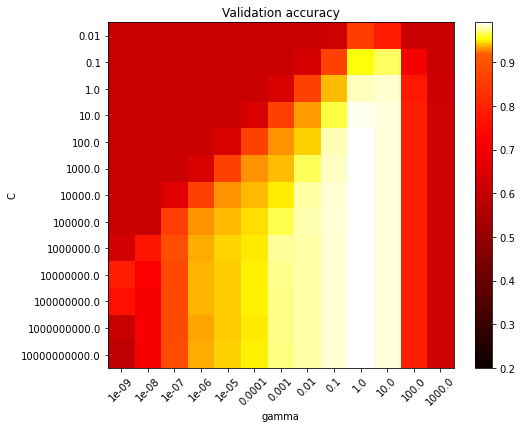


Train Metrics:

Accuracy =  1.0

F1-score =  1.0

Error =  0.0

Confusion Matrix:
 [[3073    0    0    0]
 [   0  380    0    0]
 [   0    0 1542    0]
 [   0    0    0   41]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3073
           1       1.00      1.00      1.00       380
           2       1.00      1.00      1.00      1542
           3       1.00      1.00      1.00        41

    accuracy                           1.00      5036
   macro avg       1.00      1.00      1.00      5036
weighted avg       1.00      1.00      1.00      5036

Test Metrics:

Accuracy =  0.9935155164427976

F1-score =  0.9822413271351746

Error =  0.006484483557202436

Confusion Matrix:
 [[1339    0    7    1]
 [   0  162    0    0]
 [   4    0  619    0]
 [   1    0    1   25]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1347
       

In [29]:
print("SVC on raw features and label 'Family' - using Gaussian kernels and one versus all classifiers:\n")
runSVC('rbf', 'Family', Xtrain, Ytrain, Xtest, Ytest)
Metrics.loc['rbf SVC - raw features, label: Family'] = [best_params['Family'], train_error['Family'], test_error['Family'], test_f1score['Family']]

SVC on raw features and label 'Genus' - using Gaussian kernels and one versus all classifiers:

Fitting 10 folds for each of 169 candidates, totalling 1690 fits
Grid scores on development set:

0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-09}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-08}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-07}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-06}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-05}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 0.0001}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 0.1}
0.790 (+/-0.007) for {'C': 0.01, 'gamma': 1.0}
0.721 (+/-0.011) for {'C': 0.01, 'gamma': 10.0}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1000.0}
0.575 (+/-0.000) for {'C': 0.1, 'gamma': 1e-09}
0.575 (+/-0.000) for {'C': 0.1, 'gamma': 1e-08}
0.575 (+/-0.000) for {'C': 0.1, 'gamma': 1e-07}
0.575 (+/-0.000) for {'C': 0.

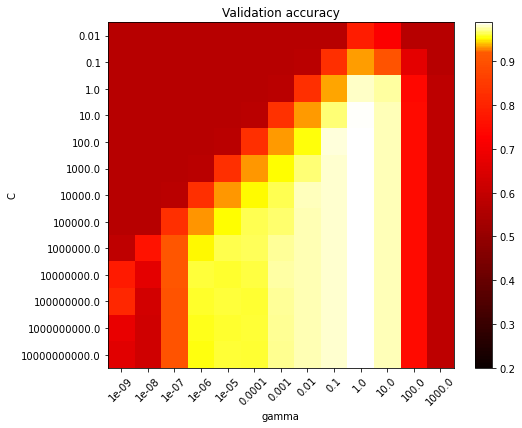


Train Metrics:

Accuracy =  1.0

F1-score =  1.0

Error =  0.0

Confusion Matrix:
 [[2899    0    0    0    0    0    0    0]
 [   0  380    0    0    0    0    0    0]
 [   0    0  226    0    0    0    0    0]
 [   0    0    0 1125    0    0    0    0]
 [   0    0    0    0  174    0    0    0]
 [   0    0    0    0    0   80    0    0]
 [   0    0    0    0    0    0   41    0]
 [   0    0    0    0    0    0    0  111]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2899
           1       1.00      1.00      1.00       380
           2       1.00      1.00      1.00       226
           3       1.00      1.00      1.00      1125
           4       1.00      1.00      1.00       174
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00       111

    accuracy                           1.00      5036
   m

In [30]:
print("SVC on raw features and label 'Genus' - using Gaussian kernels and one versus all classifiers:\n")
runSVC('rbf', 'Genus', Xtrain, Ytrain, Xtest, Ytest)
Metrics.loc['rbf SVC - raw features, label: Genus'] = [best_params['Genus'], train_error['Genus'], test_error['Genus'], test_f1score['Genus']]

SVC on raw features and label 'Species' - using Gaussian kernels and one versus all classifiers:

Fitting 10 folds for each of 169 candidates, totalling 1690 fits
Grid scores on development set:

0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-09}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-08}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-07}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-06}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-05}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 0.0001}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 0.1}
0.820 (+/-0.019) for {'C': 0.01, 'gamma': 1.0}
0.657 (+/-0.014) for {'C': 0.01, 'gamma': 10.0}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1000.0}
0.486 (+/-0.000) for {'C': 0.1, 'gamma': 1e-09}
0.486 (+/-0.000) for {'C': 0.1, 'gamma': 1e-08}
0.486 (+/-0.000) for {'C': 0.1, 'gamma': 1e-07}
0.486 (+/-0.000) for {'C': 

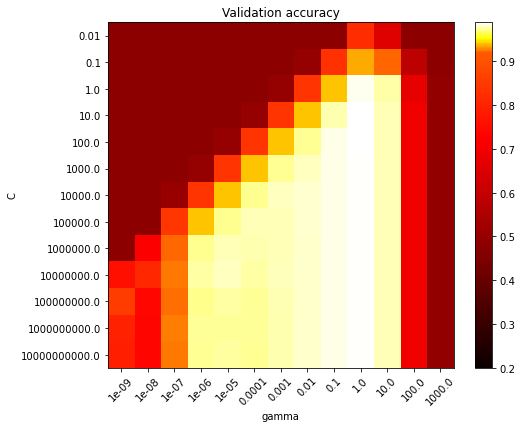


Train Metrics:

Accuracy =  0.9990071485305798

F1-score =  0.9979821114234527

Error =  0.0009928514694201862

Confusion Matrix:
 [[ 451    0    0    1    0    0    0    0    0    0]
 [   0  380    0    0    0    0    0    0    0    0]
 [   0    0 2447    0    0    0    0    0    0    0]
 [   2    0    1  223    0    0    0    0    0    0]
 [   0    0    0    0  337    0    0    0    0    0]
 [   0    0    0    0    0  788    0    0    0    0]
 [   0    0    0    0    0    0  174    0    0    0]
 [   0    0    0    0    1    0    0   79    0    0]
 [   0    0    0    0    0    0    0    0   41    0]
 [   0    0    0    0    0    0    0    0    0  111]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       452
           1       1.00      1.00      1.00       380
           2       1.00      1.00      1.00      2447
           3       1.00      0.99      0.99       226
           4       1.00      1.00      1.

In [31]:
print("SVC on raw features and label 'Species' - using Gaussian kernels and one versus all classifiers:\n")
runSVC('rbf', 'Species', Xtrain, Ytrain, Xtest, Ytest)
Metrics.loc['rbf SVC - raw features, label: Species'] = [best_params['Species'], train_error['Species'], test_error['Species'], test_f1score['Species']]

#### Evaluation of Multilabel classifier (SVC on raw features)

In [32]:
print("Evaluation of Multilabel classifier (SVC on raw features using Gaussian kernels):\n")
emr, hl = evaluate_multiclass(Ytest, test_pred)
print("Exact Match Ratio = {}\nHamming Loss = {}".format(emr, hl))
multi_label_eval.loc['rbf SVC - raw features, multilabel'] = [emr, hl]

Evaluation of Multilabel classifier (SVC on raw features using Gaussian kernels):

Exact Match Ratio = 0.9861046780917091
Hamming Loss = 0.008337193144974525


#### SVM on standardized features for each label

In [29]:
std_Xtrain = standardize(Xtrain)
std_Xtest = standardize(Xtest)

SVC on standardized features and label 'Family' - using Gaussian kernels and one versus all classifiers:

Fitting 10 folds for each of 169 candidates, totalling 1690 fits
Grid scores on development set:

0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-09}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-08}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-07}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-06}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1e-05}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 0.0001}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.829 (+/-0.023) for {'C': 0.01, 'gamma': 0.01}
0.853 (+/-0.021) for {'C': 0.01, 'gamma': 0.1}
0.626 (+/-0.010) for {'C': 0.01, 'gamma': 1.0}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 10.0}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.611 (+/-0.000) for {'C': 0.01, 'gamma': 1000.0}
0.611 (+/-0.000) for {'C': 0.1, 'gamma': 1e-09}
0.611 (+/-0.000) for {'C': 0.1, 'gamma': 1e-08}
0.611 (+/-0.000) for {'C': 0.1, 'gamma': 1e-07}
0.611 (+/-0.000) fo

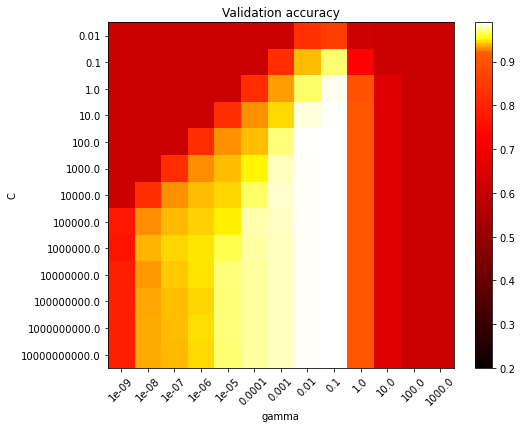


Train Metrics:

Accuracy =  1.0

F1-score =  1.0

Error =  0.0

Confusion Matrix:
 [[3073    0    0    0]
 [   0  380    0    0]
 [   0    0 1542    0]
 [   0    0    0   41]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3073
           1       1.00      1.00      1.00       380
           2       1.00      1.00      1.00      1542
           3       1.00      1.00      1.00        41

    accuracy                           1.00      5036
   macro avg       1.00      1.00      1.00      5036
weighted avg       1.00      1.00      1.00      5036

Test Metrics:

Accuracy =  0.9935155164427976

F1-score =  0.9814877151222863

Error =  0.006484483557202436

Confusion Matrix:
 [[1337    0   10    0]
 [   0  162    0    0]
 [   1    0  622    0]
 [   0    0    3   24]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1347
       

In [34]:
print("SVC on standardized features and label 'Family' - using Gaussian kernels and one versus all classifiers:\n")
runSVC('rbf', 'Family', std_Xtrain, Ytrain, std_Xtest, Ytest)
Metrics.loc['rbf SVC - std features, label: Family'] = [best_params['Family'], train_error['Family'], test_error['Family'], test_f1score['Family']]

SVC on standardized features and label 'Genus' - using Gaussian kernels and one versus all classifiers:

Fitting 10 folds for each of 169 candidates, totalling 1690 fits
Grid scores on development set:

0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-09}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-08}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-07}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-06}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1e-05}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 0.0001}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.787 (+/-0.009) for {'C': 0.01, 'gamma': 0.01}
0.780 (+/-0.016) for {'C': 0.01, 'gamma': 0.1}
0.592 (+/-0.007) for {'C': 0.01, 'gamma': 1.0}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 10.0}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.575 (+/-0.000) for {'C': 0.01, 'gamma': 1000.0}
0.575 (+/-0.000) for {'C': 0.1, 'gamma': 1e-09}
0.575 (+/-0.000) for {'C': 0.1, 'gamma': 1e-08}
0.575 (+/-0.000) for {'C': 0.1, 'gamma': 1e-07}
0.575 (+/-0.000) for

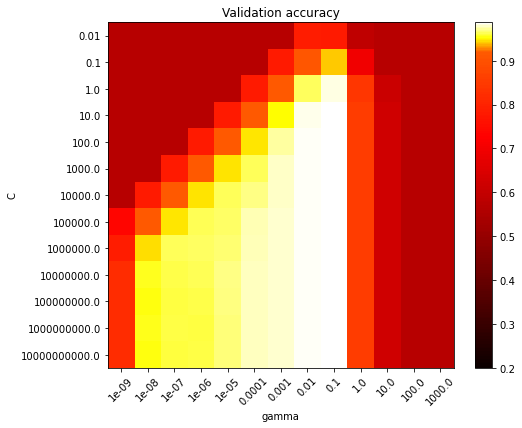


Train Metrics:

Accuracy =  1.0

F1-score =  1.0

Error =  0.0

Confusion Matrix:
 [[2899    0    0    0    0    0    0    0]
 [   0  380    0    0    0    0    0    0]
 [   0    0  226    0    0    0    0    0]
 [   0    0    0 1125    0    0    0    0]
 [   0    0    0    0  174    0    0    0]
 [   0    0    0    0    0   80    0    0]
 [   0    0    0    0    0    0   41    0]
 [   0    0    0    0    0    0    0  111]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2899
           1       1.00      1.00      1.00       380
           2       1.00      1.00      1.00       226
           3       1.00      1.00      1.00      1125
           4       1.00      1.00      1.00       174
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00       111

    accuracy                           1.00      5036
   m

In [35]:
print("SVC on standardized features and label 'Genus' - using Gaussian kernels and one versus all classifiers:\n")
runSVC('rbf', 'Genus', std_Xtrain, Ytrain, std_Xtest, Ytest)
Metrics.loc['rbf SVC - std features, label: Genus'] = [best_params['Genus'], train_error['Genus'], test_error['Genus'], test_f1score['Genus']]

SVC on standardized features and label 'Species' - using Gaussian kernels and one versus all classifiers:

Fitting 10 folds for each of 169 candidates, totalling 1690 fits
Grid scores on development set:

0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-09}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-08}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-07}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-06}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1e-05}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 0.0001}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.728 (+/-0.027) for {'C': 0.01, 'gamma': 0.01}
0.808 (+/-0.027) for {'C': 0.01, 'gamma': 0.1}
0.502 (+/-0.006) for {'C': 0.01, 'gamma': 1.0}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 10.0}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.486 (+/-0.000) for {'C': 0.01, 'gamma': 1000.0}
0.486 (+/-0.000) for {'C': 0.1, 'gamma': 1e-09}
0.486 (+/-0.000) for {'C': 0.1, 'gamma': 1e-08}
0.486 (+/-0.000) for {'C': 0.1, 'gamma': 1e-07}
0.486 (+/-0.000) f

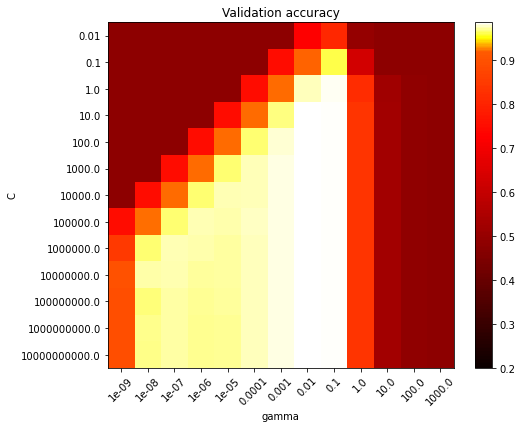


Train Metrics:

Accuracy =  0.999801429706116

F1-score =  0.9996685074769165

Error =  0.00019857029388403724

Confusion Matrix:
 [[ 451    0    0    1    0    0    0    0    0    0]
 [   0  380    0    0    0    0    0    0    0    0]
 [   0    0 2447    0    0    0    0    0    0    0]
 [   0    0    0  226    0    0    0    0    0    0]
 [   0    0    0    0  337    0    0    0    0    0]
 [   0    0    0    0    0  788    0    0    0    0]
 [   0    0    0    0    0    0  174    0    0    0]
 [   0    0    0    0    0    0    0   80    0    0]
 [   0    0    0    0    0    0    0    0   41    0]
 [   0    0    0    0    0    0    0    0    0  111]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       452
           1       1.00      1.00      1.00       380
           2       1.00      1.00      1.00      2447
           3       1.00      1.00      1.00       226
           4       1.00      1.00      1.

In [36]:
print("SVC on standardized features and label 'Species' - using Gaussian kernels and one versus all classifiers:\n")
runSVC('rbf', 'Species', std_Xtrain, Ytrain, std_Xtest, Ytest)
Metrics.loc['rbf SVC - std features, label: Species'] = [best_params['Species'], train_error['Species'], test_error['Species'], test_f1score['Species']]

#### Evaluation of Multilabel classifier (SVC on standardized features)

In [37]:
print("Evaluation of Multilabel classifier (SVC on standardized features using Gaussian kernels):\n")
emr, hl = evaluate_multiclass(Ytest, test_pred)
print("Exact Match Ratio ={}\nHamming Loss = {}".format(emr, hl))
multi_label_eval.loc['rbf SVC - std features, multilabel'] = [emr, hl]

Evaluation of Multilabel classifier (SVC on standardized features using Gaussian kernels):

Exact Match Ratio =0.9823992589161649
Hamming Loss = 0.010035510267098965


### Repeat 1.2.2 with L1-penalized SVMs. Remember to standardize the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

#### SVM on raw features for each label

In [26]:
print("L1-penalized SVC on raw features and label 'Family' using linear kernels:\n")
runSVC('linear', 'Family', Xtrain, Ytrain, Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - raw features, label: Family'] = [best_params['Family'], train_error['Family'], test_error['Family'], test_f1score['Family']]

L1-penalized SVC on raw features and label 'Family' using linear kernels:

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Grid scores on development set:

0.879 (+/-0.017) for {'C': 0.01}
0.928 (+/-0.021) for {'C': 0.1}
0.934 (+/-0.022) for {'C': 1.0}
0.936 (+/-0.025) for {'C': 10.0}
0.936 (+/-0.026) for {'C': 100.0}
0.936 (+/-0.026) for {'C': 1000.0}
0.936 (+/-0.026) for {'C': 10000.0}
0.936 (+/-0.026) for {'C': 100000.0}
0.936 (+/-0.026) for {'C': 1000000.0}
0.936 (+/-0.026) for {'C': 10000000.0}
0.936 (+/-0.026) for {'C': 100000000.0}
0.936 (+/-0.026) for {'C': 1000000000.0}
0.936 (+/-0.026) for {'C': 10000000000.0}

The best parameters are {'C': 10.0} with a score of 0.94

Train Metrics:

Accuracy =  0.9418189038919778

F1-score =  0.6957029569457829

Error =  0.058181096108022246

Confusion Matrix:
 [[2997   22   54    0]
 [   9  346   25    0]
 [ 122   20 1400    0]
 [   5    0   36    0]]

Classification Report:
               precision    recall  f1-score   supp

In [ ]:
print("L1-penalized SVC on raw features and label 'Genus' using linear kernels:\n")
runSVC('linear', 'Genus', Xtrain, Ytrain, Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - raw features, label: Genus'] = [best_params['Genus'], train_error['Genus'], test_error['Genus'], test_f1score['Genus']]

In [ ]:
print("L1-penalized SVC on raw features and label 'Species' using linear kernels:\n")
runSVC('linear', 'Species', Xtrain, Ytrain, Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - raw features, label: Species'] = [best_params['Species'], train_error['Species'], test_error['Species'], test_f1score['Species']]

#### Evaluation of Multilabel classifier (SVC on raw features)

In [ ]:
print("Evaluation of Multilabel classifier (L1-penalized SVC on raw features using linear kernels):\n")
emr, hl = evaluate_multiclass(Ytest, test_pred)
print("Exact Match Ratio ={}\nHamming Loss = {}".format(emr, hl))
multi_label_eval.loc['L1-penalized linear SVC - raw features, multilabel'] = [emr, hl]

#### SVM on standardized features for each label

In [ ]:
print("L1-penalized SVC on standardized features and label 'Family' using linear kernels:\n")
runSVC('linear', 'Family', std_Xtrain, Ytrain, std_Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - std features, label: Family'] = [best_params['Family'], train_error['Family'], test_error['Family'], test_f1score['Family']]

In [ ]:
print("L1-penalized SVC on standardized features and label 'Genus' using linear kernels:\n")
runSVC('linear', 'Genus', std_Xtrain, Ytrain, std_Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - std features, label: Genus'] = [best_params['Genus'], train_error['Genus'], test_error['Genus'], test_f1score['Genus']]

In [ ]:
print("L1-penalized SVC on standardized features and label 'Species' using linear kernels:\n")
runSVC('linear', 'Species', std_Xtrain, Ytrain, std_Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - std features, label: Species'] = [best_params['Species'], train_error['Species'], test_error['Species'], test_f1score['Species']]

#### Evaluation of Multilabel classifier (SVC on standardized features)

In [ ]:
print("Evaluation of Multilabel classifier (L1-penalized SVC on standardized features using linear kernels):\n")
emr, hl = evaluate_multiclass(Ytest, test_pred)
print("Exact Match Ratio ={}\nHamming Loss = {}".format(emr, hl))
multi_label_eval.loc['L1-penalized linear SVC - std features, multilabel'] = [emr, hl]

### Repeat 1.2.3 by using SMOTE or any other method you know to remedy class imbalance.

#### SVM on raw features for each label

In [46]:
print("L1-penalized SVC on raw features and label 'Family' using linear kernels and SMOTE sampling:\n")
oversample = SMOTE()
Xtrain_smote_Family, Ytrain_smote_Family = oversample.fit_resample(Xtrain, Ytrain['Family'])
Xtrain_smote_Family = pd.DataFrame(Xtrain_smote_Family, columns = Xtrain.columns)
Ytrain_smote_Family = pd.DataFrame(Ytrain_smote_Family, columns = ['Family'])
runSVC('linear', 'Family', Xtrain_smote_Family, Ytrain_smote_Family, Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - raw features, label: Family with SMOTE sampling'] = [best_params['Family'], train_error['Family'], test_error['Family'], test_f1score['Family']]

L1-penalized SVC on raw features and label 'Family' using linear kernels and SMOTE sampling:

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Grid scores on development set:

0.885 (+/-0.015) for {'C': 0.01}
0.936 (+/-0.014) for {'C': 0.1}
0.949 (+/-0.013) for {'C': 1.0}
0.950 (+/-0.011) for {'C': 10.0}
0.950 (+/-0.011) for {'C': 100.0}
0.950 (+/-0.011) for {'C': 1000.0}
0.950 (+/-0.011) for {'C': 10000.0}
0.950 (+/-0.011) for {'C': 100000.0}
0.950 (+/-0.011) for {'C': 1000000.0}
0.950 (+/-0.011) for {'C': 10000000.0}
0.950 (+/-0.011) for {'C': 100000000.0}
0.950 (+/-0.011) for {'C': 1000000000.0}
0.950 (+/-0.011) for {'C': 10000000000.0}

The best parameters are {'C': 10.0} with a score of 0.95

Train Metrics:

Accuracy =  0.950130165961601

F1-score =  0.949585149548219

Error =  0.04986983403839895

Confusion Matrix:
 [[2875   52   81   65]
 [  15 3053    5    0]
 [ 175   99 2709   90]
 [   0    0   31 3042]]

Classification Report:
               precision    recall 

In [47]:
print("L1-penalized SVC on raw features and label 'Genus' using linear kernels and SMOTE sampling:\n")
oversample = SMOTE()
Xtrain_smote_Genus, Ytrain_smote_Genus = oversample.fit_resample(Xtrain, Ytrain['Genus'])
Xtrain_smote_Genus = pd.DataFrame(Xtrain_smote_Genus, columns = Xtrain.columns)
Ytrain_smote_Genus = pd.DataFrame(Ytrain_smote_Genus, columns = ['Genus'])
runSVC('linear', 'Genus', Xtrain_smote_Genus, Ytrain_smote_Genus, Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - raw features, label: Genus with SMOTE sampling'] = [best_params['Genus'], train_error['Genus'], test_error['Genus'], test_f1score['Genus']]

L1-penalized SVC on raw features and label 'Genus' using linear kernels and SMOTE sampling:

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Grid scores on development set:

0.907 (+/-0.013) for {'C': 0.01}
0.943 (+/-0.009) for {'C': 0.1}
0.953 (+/-0.010) for {'C': 1.0}
0.954 (+/-0.009) for {'C': 10.0}
0.954 (+/-0.009) for {'C': 100.0}
0.954 (+/-0.009) for {'C': 1000.0}
0.954 (+/-0.009) for {'C': 10000.0}
0.954 (+/-0.009) for {'C': 100000.0}
0.954 (+/-0.009) for {'C': 1000000.0}
0.954 (+/-0.009) for {'C': 10000000.0}
0.954 (+/-0.009) for {'C': 100000000.0}
0.954 (+/-0.009) for {'C': 1000000000.0}
0.954 (+/-0.009) for {'C': 10000000000.0}

The best parameters are {'C': 1000.0} with a score of 0.95

Train Metrics:

Accuracy =  0.9557174887892377

F1-score =  0.9556500704441951

Error =  0.04428251121076232

Confusion Matrix:
 [[2646   59   82   19    0   43   48    2]
 [  12 2833   51    0    0    0    3    0]
 [ 158    8 2618   48    0    0   67    0]
 [  48    0    6 270

In [48]:
print("L1-penalized SVC on raw features and label 'Species' using linear kernels and SMOTE sampling:\n")
oversample = SMOTE()
Xtrain_smote_Species, Ytrain_smote_Species = oversample.fit_resample(Xtrain, Ytrain['Species'])
Xtrain_smote_Species = pd.DataFrame(Xtrain_smote_Species, columns = Xtrain.columns)
Ytrain_smote_Species = pd.DataFrame(Ytrain_smote_Species, columns = ['Species'])
runSVC('linear', 'Species', Xtrain_smote_Species, Ytrain_smote_Species, Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - raw features, label: Species with SMOTE sampling'] = [best_params['Species'], train_error['Species'], test_error['Species'], test_f1score['Species']]

L1-penalized SVC on raw features and label 'Species' using linear kernels and SMOTE sampling:

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Grid scores on development set:

0.912 (+/-0.007) for {'C': 0.01}
0.945 (+/-0.008) for {'C': 0.1}
0.956 (+/-0.007) for {'C': 1.0}
0.959 (+/-0.007) for {'C': 10.0}
0.959 (+/-0.007) for {'C': 100.0}
0.959 (+/-0.007) for {'C': 1000.0}
0.959 (+/-0.007) for {'C': 10000.0}
0.959 (+/-0.007) for {'C': 100000.0}
0.959 (+/-0.007) for {'C': 1000000.0}
0.959 (+/-0.007) for {'C': 10000000.0}
0.959 (+/-0.007) for {'C': 100000000.0}
0.959 (+/-0.007) for {'C': 1000000000.0}
0.959 (+/-0.007) for {'C': 10000000000.0}

The best parameters are {'C': 100000000.0} with a score of 0.96

Train Metrics:

Accuracy =  0.959950960359624

F1-score =  0.9599105858359194

Error =  0.04004903964037598

Confusion Matrix:
 [[2299   86    0   30    1   15    0    7    5    4]
 [   8 2357    0   68    0    7    0    0    7    0]
 [   0    1 2430    4    3    3    0 

#### Evaluation of Multilabel classifier (SVC on raw features)

In [49]:
print("Evaluation of Multilabel classifier (L1-penalized SVC on raw features using linear kernels and SMOTE sampling):\n")
emr, hl = evaluate_multiclass(Ytest, test_pred)
print("Exact Match Ratio ={}\nHamming Loss = {}".format(emr, hl))
multi_label_eval.loc['L1-penalized linear SVC - raw features, multilabel with SMOTE sampling'] = [emr, hl]

Evaluation of Multilabel classifier (L1-penalized SVC on raw features using linear kernels and SMOTE sampling):

Exact Match Ratio =0.8578045391384901
Hamming Loss = 0.07596109309865678


#### SVM on standardized features for each label

In [50]:
print("L1-penalized SVC on standardized features and label 'Family' using linear kernels and SMOTE sampling:\n")
oversample = SMOTE()
Xtrain_smote_Family, Ytrain_smote_Family = oversample.fit_resample(std_Xtrain, Ytrain['Family'])
Xtrain_smote_Family = pd.DataFrame(Xtrain_smote_Family, columns = Xtrain.columns)
Ytrain_smote_Family = pd.DataFrame(Ytrain_smote_Family, columns = ['Family'])
runSVC('linear', 'Family', Xtrain_smote_Family, Ytrain_smote_Family, std_Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - std features, label: Family with SMOTE sampling'] = [best_params['Family'], train_error['Family'], test_error['Family'], test_f1score['Family']]

L1-penalized SVC on standardized features and label 'Family' using linear kernels and SMOTE sampling:

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Grid scores on development set:

0.934 (+/-0.014) for {'C': 0.01}
0.949 (+/-0.009) for {'C': 0.1}
0.950 (+/-0.009) for {'C': 1.0}
0.950 (+/-0.009) for {'C': 10.0}
0.951 (+/-0.009) for {'C': 100.0}
0.951 (+/-0.009) for {'C': 1000.0}
0.951 (+/-0.009) for {'C': 10000.0}
0.951 (+/-0.009) for {'C': 100000.0}
0.951 (+/-0.009) for {'C': 1000000.0}
0.951 (+/-0.009) for {'C': 10000000.0}
0.951 (+/-0.009) for {'C': 100000000.0}
0.951 (+/-0.009) for {'C': 1000000000.0}
0.951 (+/-0.009) for {'C': 10000000000.0}

The best parameters are {'C': 100.0} with a score of 0.95

Train Metrics:

Accuracy =  0.952245362837618

F1-score =  0.9516539302854954

Error =  0.04775463716238204

Confusion Matrix:
 [[2888   47   84   54]
 [   9 3057    4    3]
 [ 168  102 2703  100]
 [   0    0   16 3057]]

Classification Report:
               precision

In [51]:
print("L1-penalized SVC on standardized features and label 'Genus' using linear kernels and SMOTE sampling:\n")
oversample = SMOTE()
Xtrain_smote_Genus, Ytrain_smote_Genus = oversample.fit_resample(std_Xtrain, Ytrain['Genus'])
Xtrain_smote_Genus = pd.DataFrame(Xtrain_smote_Genus, columns = Xtrain.columns)
Ytrain_smote_Genus = pd.DataFrame(Ytrain_smote_Genus, columns = ['Genus'])
runSVC('linear', 'Genus', Xtrain_smote_Genus, Ytrain_smote_Genus, std_Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - std features, label: Genus with SMOTE sampling'] = [best_params['Genus'], train_error['Genus'], test_error['Genus'], test_f1score['Genus']]

L1-penalized SVC on standardized features and label 'Genus' using linear kernels and SMOTE sampling:

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Grid scores on development set:

0.941 (+/-0.008) for {'C': 0.01}
0.955 (+/-0.009) for {'C': 0.1}
0.958 (+/-0.008) for {'C': 1.0}
0.958 (+/-0.008) for {'C': 10.0}
0.958 (+/-0.008) for {'C': 100.0}
0.958 (+/-0.008) for {'C': 1000.0}
0.958 (+/-0.008) for {'C': 10000.0}
0.958 (+/-0.008) for {'C': 100000.0}
0.958 (+/-0.008) for {'C': 1000000.0}
0.958 (+/-0.008) for {'C': 10000000.0}
0.958 (+/-0.008) for {'C': 100000000.0}
0.958 (+/-0.008) for {'C': 1000000000.0}
0.958 (+/-0.008) for {'C': 10000000000.0}

The best parameters are {'C': 10000000000.0} with a score of 0.96

Train Metrics:

Accuracy =  0.9601586754053122

F1-score =  0.9601183386638834

Error =  0.03984132459468781

Confusion Matrix:
 [[2647   47   83   22    0   43   55    2]
 [   7 2835   53    1    1    0    2    0]
 [ 133   15 2673   29    0    0   49    0]
 [  

In [52]:
print("L1-penalized SVC on standardized features and label 'Species' using linear kernels and SMOTE sampling:\n")
oversample = SMOTE()
Xtrain_smote_Species, Ytrain_smote_Species = oversample.fit_resample(std_Xtrain, Ytrain['Species'])
Xtrain_smote_Species = pd.DataFrame(Xtrain_smote_Species, columns = Xtrain.columns)
Ytrain_smote_Species = pd.DataFrame(Ytrain_smote_Species, columns = ['Species'])
runSVC('linear', 'Species', Xtrain_smote_Species, Ytrain_smote_Species, std_Xtest, Ytest)
Metrics.loc['L1-penalized linear SVC - std features, label: Species with SMOTE sampling'] = [best_params['Species'], train_error['Species'], test_error['Species'], test_f1score['Species']]

L1-penalized SVC on standardized features and label 'Species' using linear kernels and SMOTE sampling:

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Grid scores on development set:

0.943 (+/-0.007) for {'C': 0.01}
0.959 (+/-0.006) for {'C': 0.1}
0.963 (+/-0.007) for {'C': 1.0}
0.963 (+/-0.007) for {'C': 10.0}
0.963 (+/-0.008) for {'C': 100.0}
0.963 (+/-0.008) for {'C': 1000.0}
0.963 (+/-0.008) for {'C': 10000.0}
0.963 (+/-0.008) for {'C': 100000.0}
0.963 (+/-0.008) for {'C': 1000000.0}
0.963 (+/-0.008) for {'C': 10000000.0}
0.963 (+/-0.008) for {'C': 100000000.0}
0.963 (+/-0.008) for {'C': 1000000000.0}
0.963 (+/-0.008) for {'C': 10000000000.0}

The best parameters are {'C': 10.0} with a score of 0.96

Train Metrics:

Accuracy =  0.9635472006538619

F1-score =  0.9635329922754228

Error =  0.0364527993461381

Confusion Matrix:
 [[2310   83    0   20    6   11    0   10    5    2]
 [  12 2352    0   70    0    7    1    0    5    0]
 [   0    1 2429    5    4    2    

#### Evaluation of Multilabel classifier (SVC on standardized features)

In [53]:
print("Evaluation of Multilabel classifier (L1-penalized SVC on standardized features using linear kernels and SMOTE sampling):\n")
emr, hl = evaluate_multiclass(Ytest, test_pred)
print("Exact Match Ratio ={}\nHamming Loss = {}".format(emr, hl))
multi_label_eval.loc['L1-penalized linear SVC - std features, multilabel with SMOTE sampling'] = [emr, hl]

Evaluation of Multilabel classifier (L1-penalized SVC on standardized features using linear kernels and SMOTE sampling):

Exact Match Ratio =0.8693839740620658
Hamming Loss = 0.0725644588544079


#### Report your conclusions about the classifiers you trained.

In [54]:
multi_label_eval

,Exact Match Ratio,Hamming Loss
"rbf SVC - raw features, multilabel",0.986105,0.008337
"rbf SVC - std features, multilabel",0.982399,0.010036
"L1-penalized linear SVC - raw features, multilabel",0.910144,0.057280
"L1-penalized linear SVC - std features, multilabel",0.909217,0.058515
"L1-penalized linear SVC - raw features, multilabel with SMOTE sampling",0.857805,0.075961
"L1-penalized linear SVC - std features, multilabel with SMOTE sampling",0.869384,0.072564


Comparing between the three classifiers trained for this Multi-class and Multi-label data set, we can observe that the performance of SVC using Gaussian kernels and one versus all classifiers is the best with Exact match ratio of around 0.99 and Hamming loss 0.01.

In [55]:
Metrics

,Best params,Train Error,Test Error,F1-score
"rbf SVC - raw features, label: Family","{'C': 100.0, 'gamma': 1.0}",0.000000,0.006484,0.982241
"rbf SVC - raw features, label: Genus","{'C': 100.0, 'gamma': 1.0}",0.000000,0.007874,0.973125
"rbf SVC - raw features, label: Species","{'C': 10.0, 'gamma': 1.0}",0.000993,0.010653,0.969553
"rbf SVC - std features, label: Family","{'C': 100.0, 'gamma': 0.1}",0.000000,0.006484,0.981488
"rbf SVC - std features, label: Genus","{'C': 10.0, 'gamma': 0.1}",0.000000,0.011579,0.961949
"rbf SVC - std features, label: Species","{'C': 100.0, 'gamma': 0.01}",0.000199,0.012043,0.966773
"L1-penalized linear SVC - raw features, label: Family",{'C': 100.0},0.057387,0.073645,0.678202
"L1-penalized linear SVC - raw features, label: Genus",{'C': 1000.0},0.043288,0.059287,0.808305
"L1-penalized linear SVC - raw features, label: Species",{'C': 10.0},0.036934,0.038907,0.908081
"L1-penalized linear SVC - std features, label: Family",{'C': 100.0},0.056791,0.074108,0.679760


# K-Means Clustering on a Multi-Class and Multi-Label Data Set

**Monte-Carlo Simulation:**<br>
Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.

1. Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1,2, . . . ,50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know. <br>
2. In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species. <br>
3. Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters.

*************************************Run 1******************************************

Optimal k selected = 4 with average silhouette score of 0.3786.


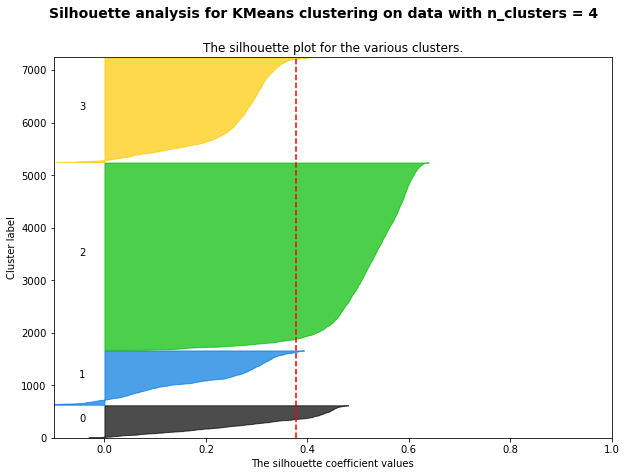


Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0                Hylidae  Hypsiboas    HypsiboasCinerascens
1          Dendrobatidae   Ameerega      Ameeregatrivittata
2        Leptodactylidae  Adenomera  AdenomeraHylaedactylus
3                Hylidae  Hypsiboas       HypsiboasCordobae

Avg Hamming Distance = 1197.5, Avg Hamming Score = 0.7067, Avg Hamming Loss = 0.2808

*************************************Run 2******************************************

Optimal k selected = 4 with average silhouette score of 0.37875.

Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0                Hylidae  Hypsiboas       HypsiboasCordobae
1        Leptodactylidae  Adenomera  AdenomeraHylaedactylus
2          Dendrobatidae   Ameerega      Ameeregatrivittata
3           

Optimal k selected = 4 with average silhouette score of 0.37875.

Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0                Hylidae  Hypsiboas    HypsiboasCinerascens
1        Leptodactylidae  Adenomera  AdenomeraHylaedactylus
2          Dendrobatidae   Ameerega      Ameeregatrivittata
3                Hylidae  Hypsiboas       HypsiboasCordobae

Avg Hamming Distance = 1200.25, Avg Hamming Score = 0.7053, Avg Hamming Loss = 0.2821

*************************************Run 15******************************************

Optimal k selected = 4 with average silhouette score of 0.37875.

Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0                Hylidae  Hypsiboas       HypsiboasCordobae
1        Leptodactylidae  Adenomera  AdenomeraHylaedactylus
2    

Optimal k selected = 4 with average silhouette score of 0.37875.

Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0        Leptodactylidae  Adenomera  AdenomeraHylaedactylus
1          Dendrobatidae   Ameerega      Ameeregatrivittata
2                Hylidae  Hypsiboas       HypsiboasCordobae
3                Hylidae  Hypsiboas    HypsiboasCinerascens

Avg Hamming Distance = 1198.75, Avg Hamming Score = 0.7054, Avg Hamming Loss = 0.282

*************************************Run 28******************************************

Optimal k selected = 4 with average silhouette score of 0.37875.

Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0        Leptodactylidae  Adenomera  AdenomeraHylaedactylus
1                Hylidae  Hypsiboas       HypsiboasCordobae
2     

*************************************Run 40******************************************

Optimal k selected = 4 with average silhouette score of 0.37875.

Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0                Hylidae  Hypsiboas       HypsiboasCordobae
1        Leptodactylidae  Adenomera  AdenomeraHylaedactylus
2        Leptodactylidae  Adenomera          AdenomeraAndre
3                Hylidae  Hypsiboas       HypsiboasCordobae

Avg Hamming Distance = 1322.75, Avg Hamming Score = 0.6454, Avg Hamming Loss = 0.3181

*************************************Run 41******************************************

Optimal k selected = 4 with average silhouette score of 0.37875.

Majority Labels per Cluster and Class are:
                   Family      Genus                 Species
Cluster                                                    
0                Hylidae  Hypsiboas   

In [77]:
# num_runs = 50, num_clusters = 50
master_df = MonteCarlo(50, 50)

In [90]:
master_df = master_df.astype('double')
master_df

,Best K,Hamming Distance,Hamming Score,Hamming Loss
Run,,,,
1,4.0,1197.50,0.706710,0.280783
2,4.0,1200.25,0.705270,0.282108
3,4.0,1200.25,0.705270,0.282108
4,4.0,1200.25,0.705270,0.282108
5,4.0,1200.25,0.705270,0.282107
6,4.0,1200.50,0.704812,0.282517
7,4.0,1200.25,0.705270,0.282108
8,4.0,1200.25,0.705270,0.282108
9,4.0,1200.25,0.705270,0.282108


In [92]:
print("Average of the 50 Hamming Distances =", np.mean(master_df)[1])
print("\nStandard deviation of the 50 Hamming Distances =", round(np.std(master_df)[1], 5))

Average of the 50 Hamming Distances = 1204.855

Standard deviation of the 50 Hamming Distances = 24.078


In [96]:
np.mean(master_df)

Best K                 4.000000
Hamming Distance    1204.855000
Hamming Score          0.702960
Hamming Loss           0.283468
dtype: float64

In [97]:
np.std(master_df)

Best K               0.000000
Hamming Distance    24.078003
Hamming Score        0.011756
Hamming Loss         0.007072
dtype: float64

# ISLR 10.7.2

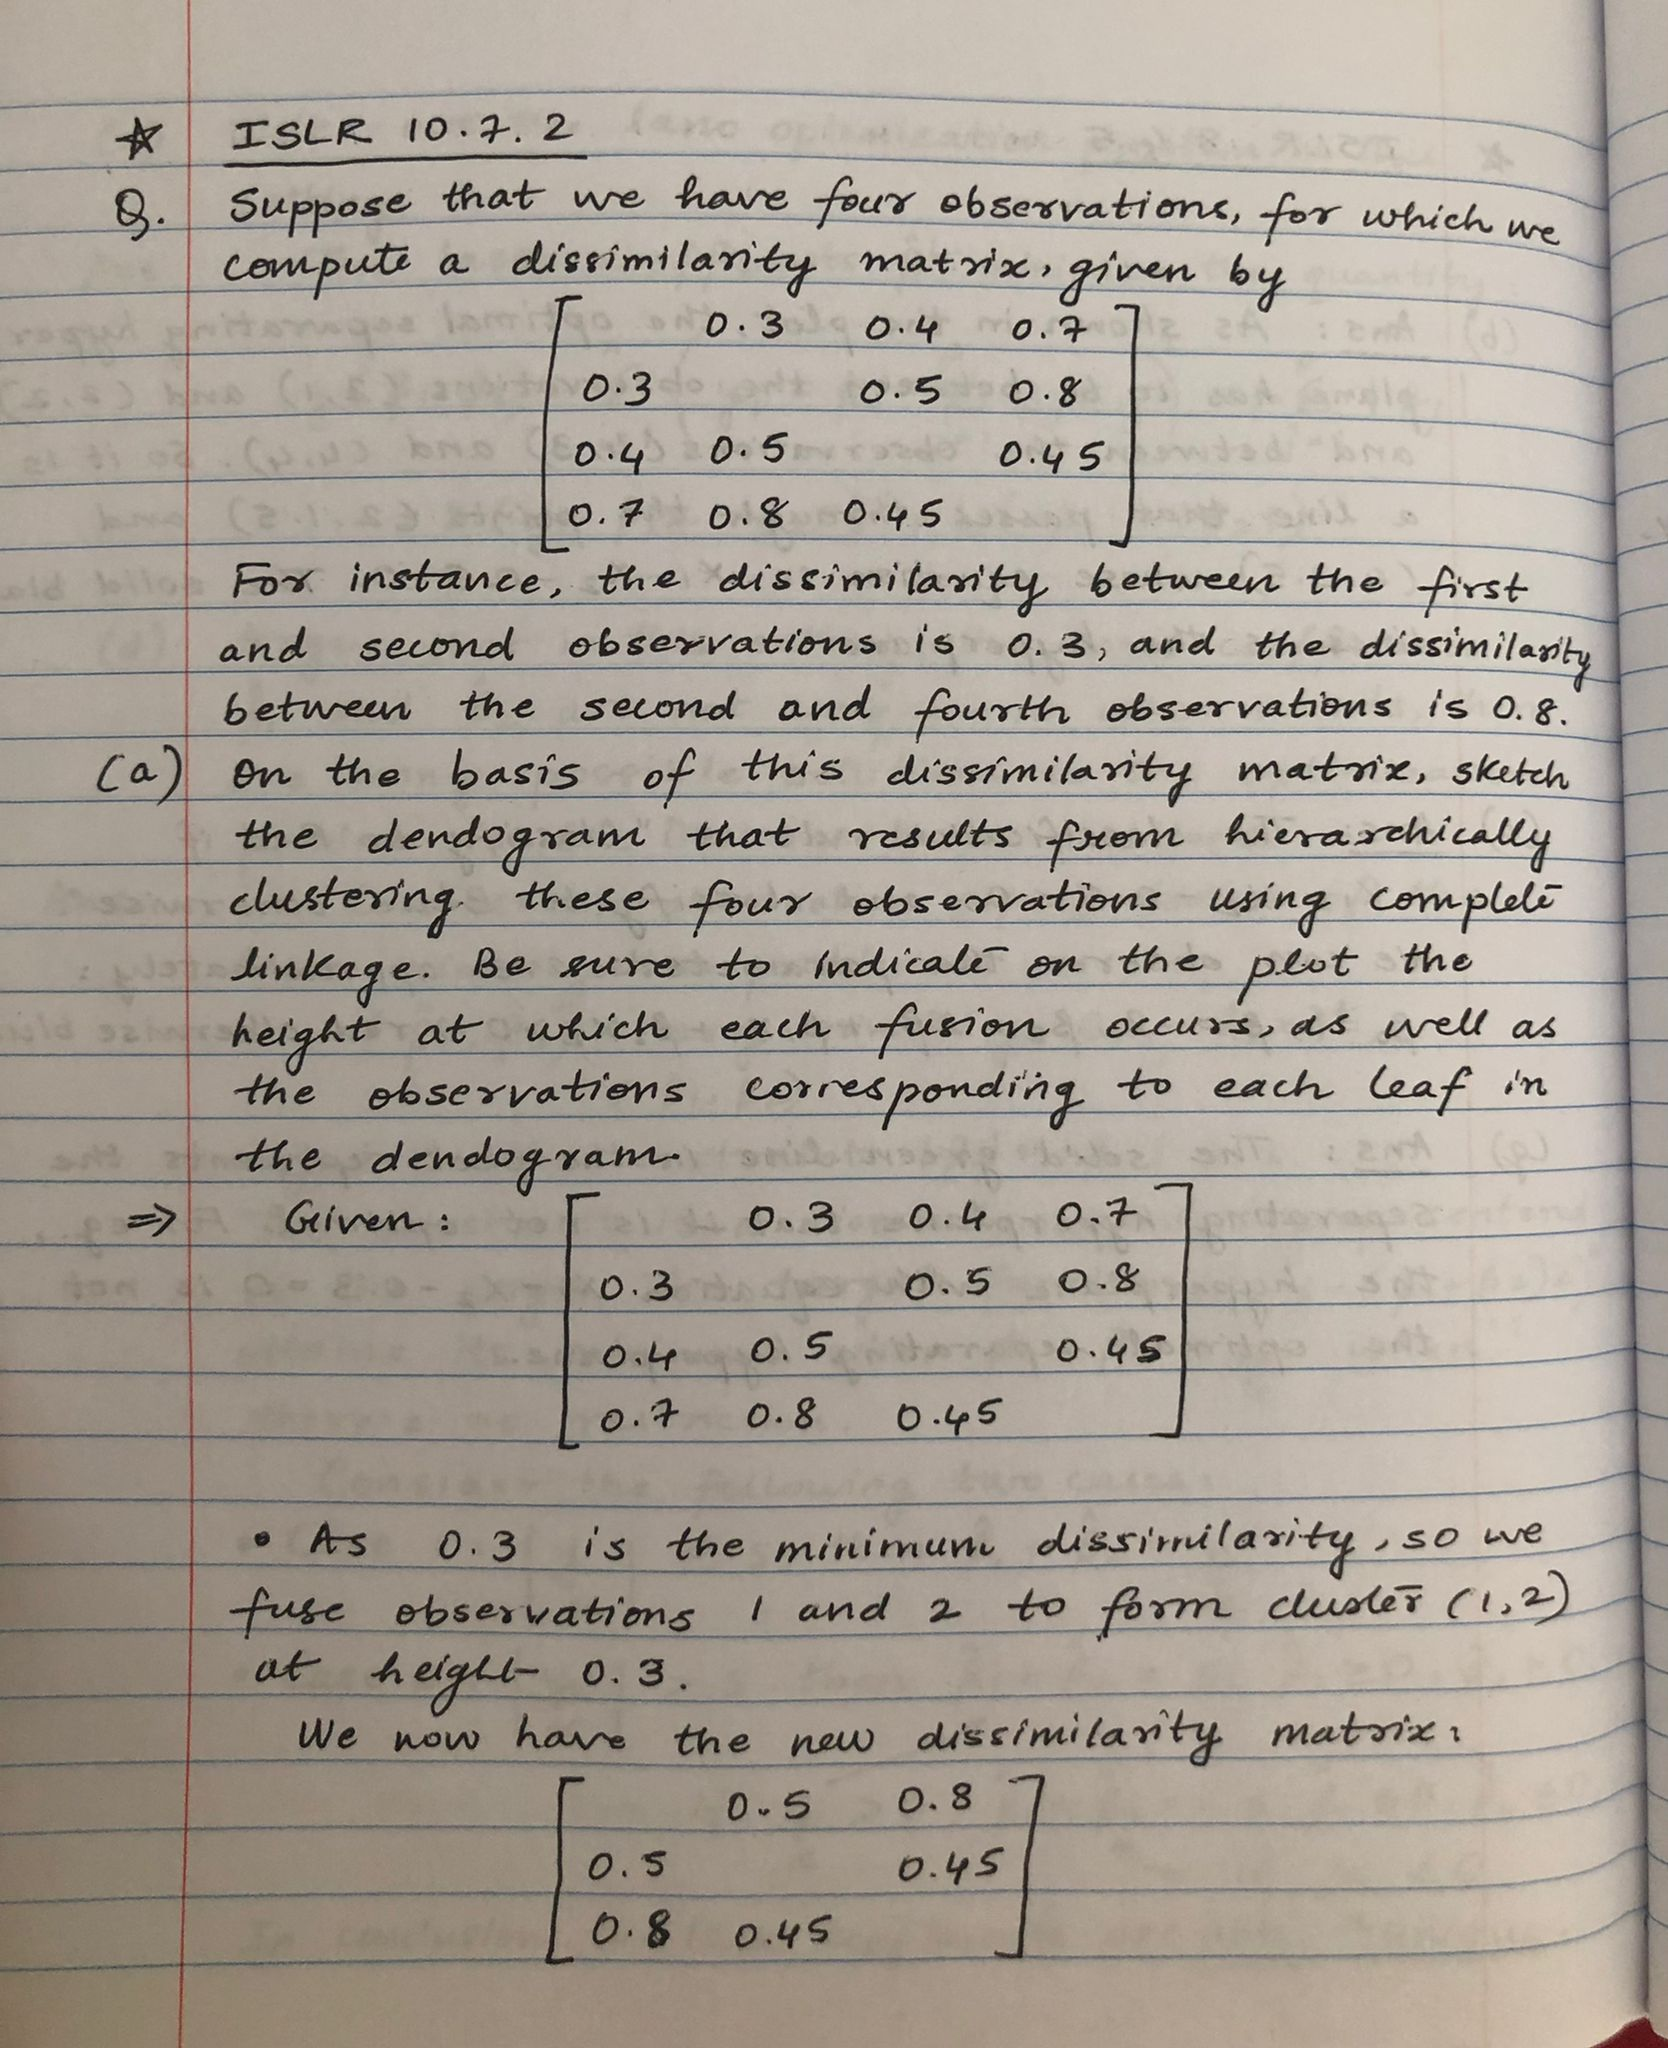

In [100]:
from IPython.display import Image
# Qsn (a)
Image('../image/ISLR_10.7.2_1.jpeg')

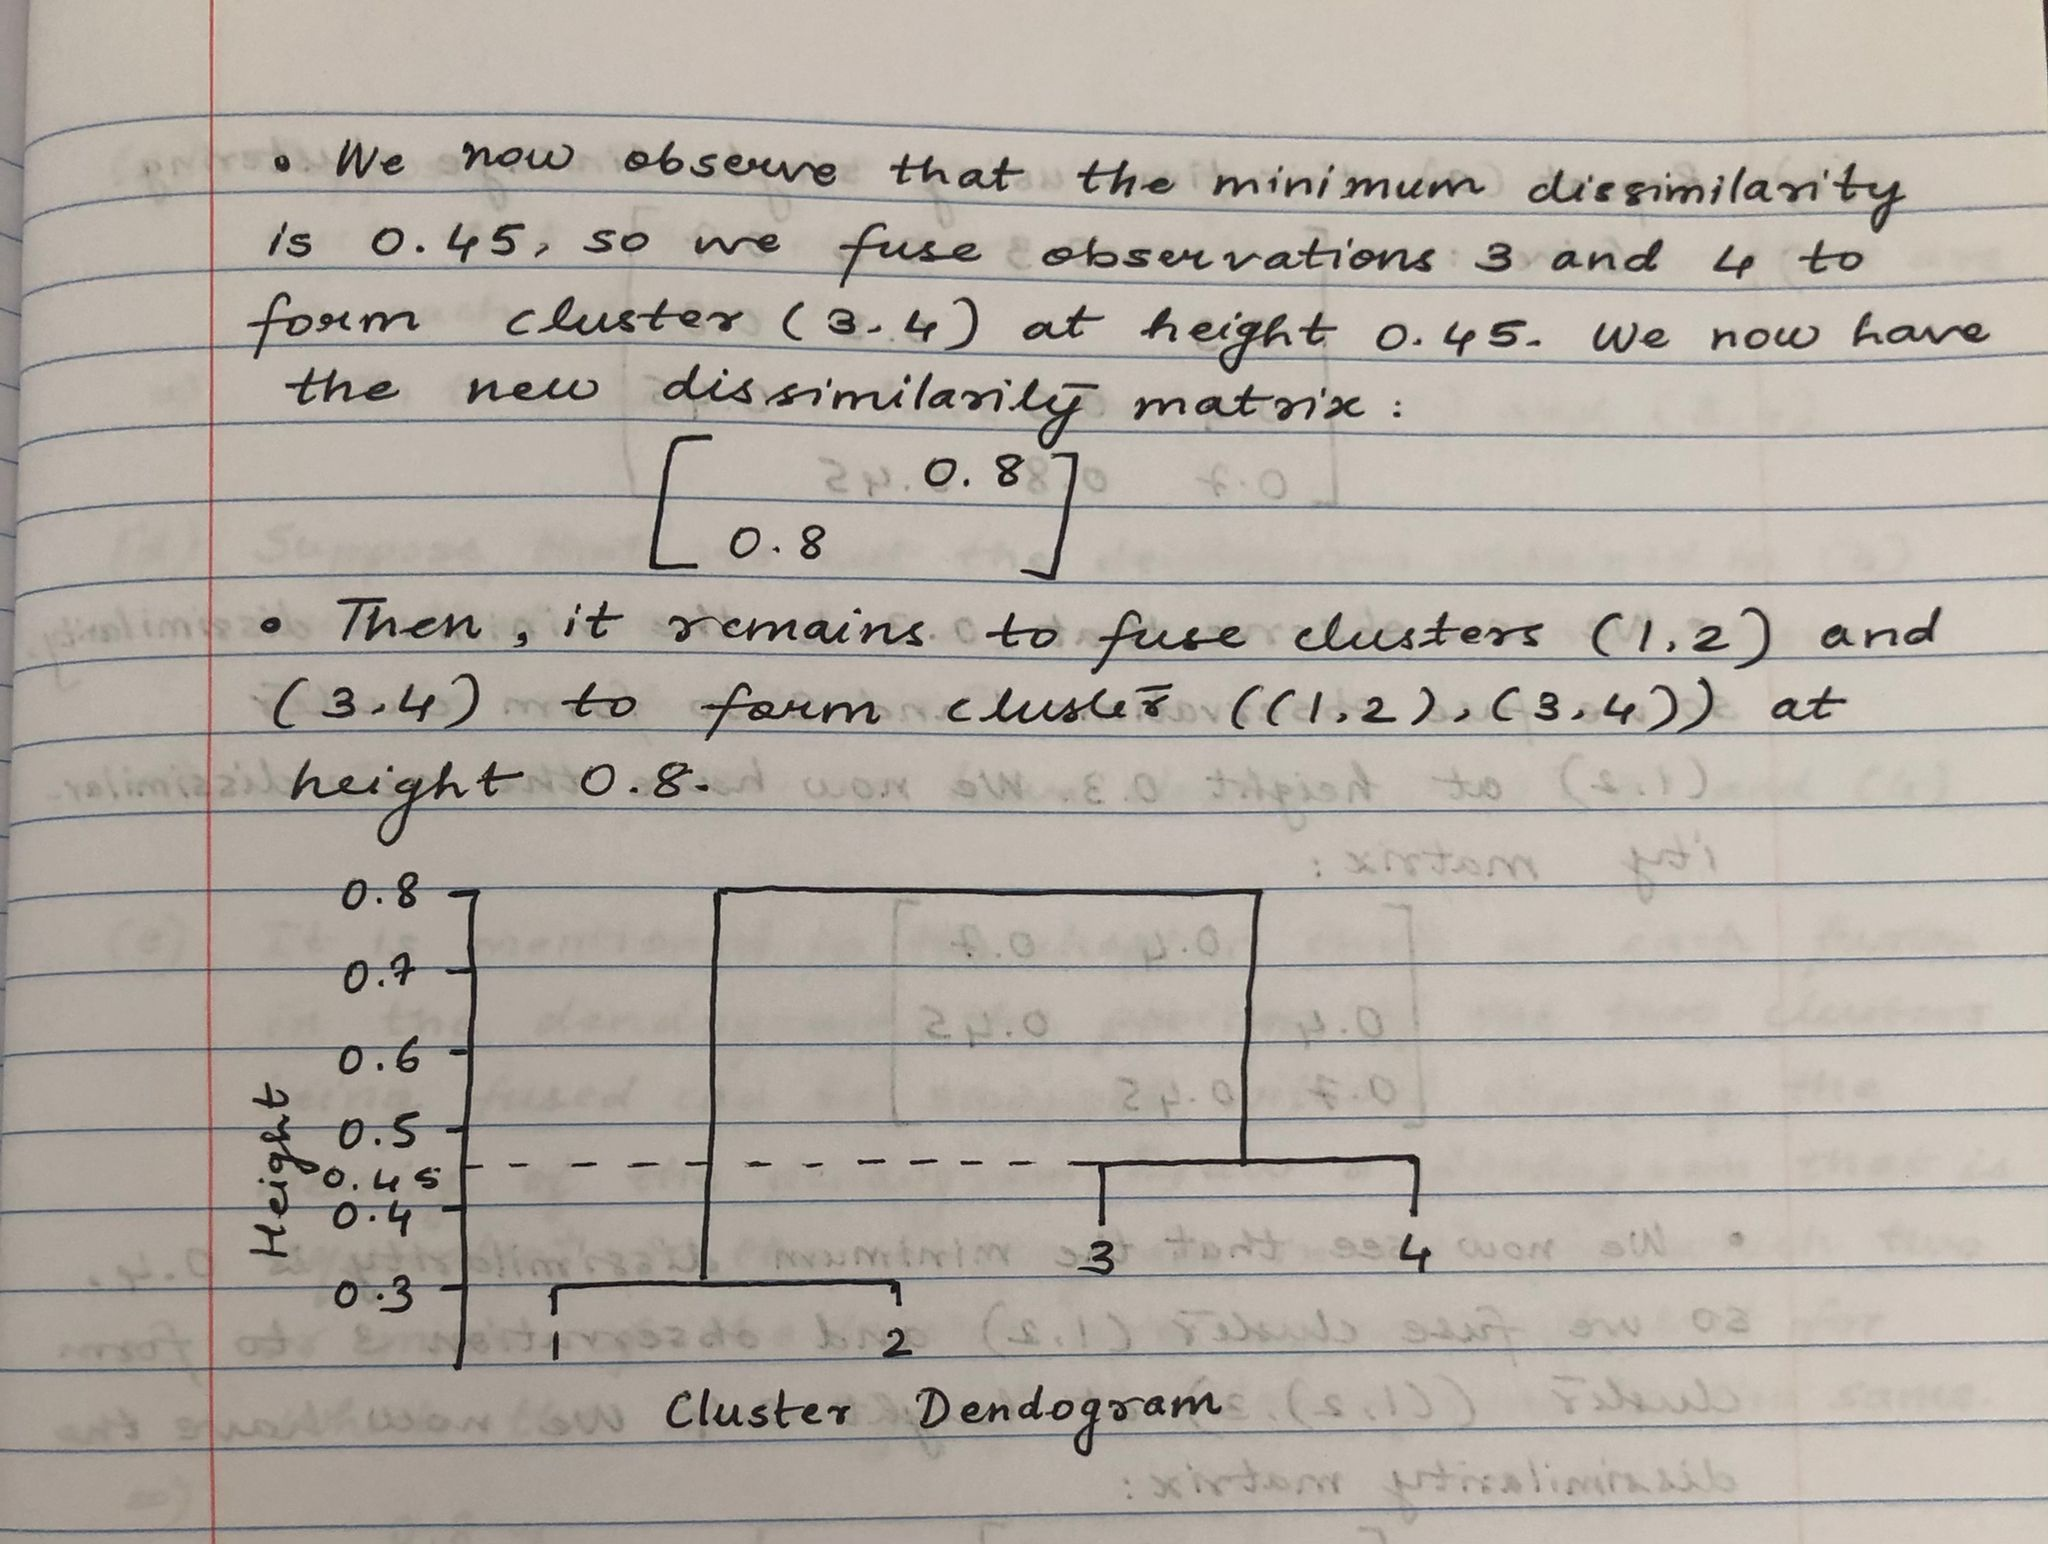

In [101]:
# Qsn (a) contd.
Image('../image/ISLR_10.7.2_2.jpeg')

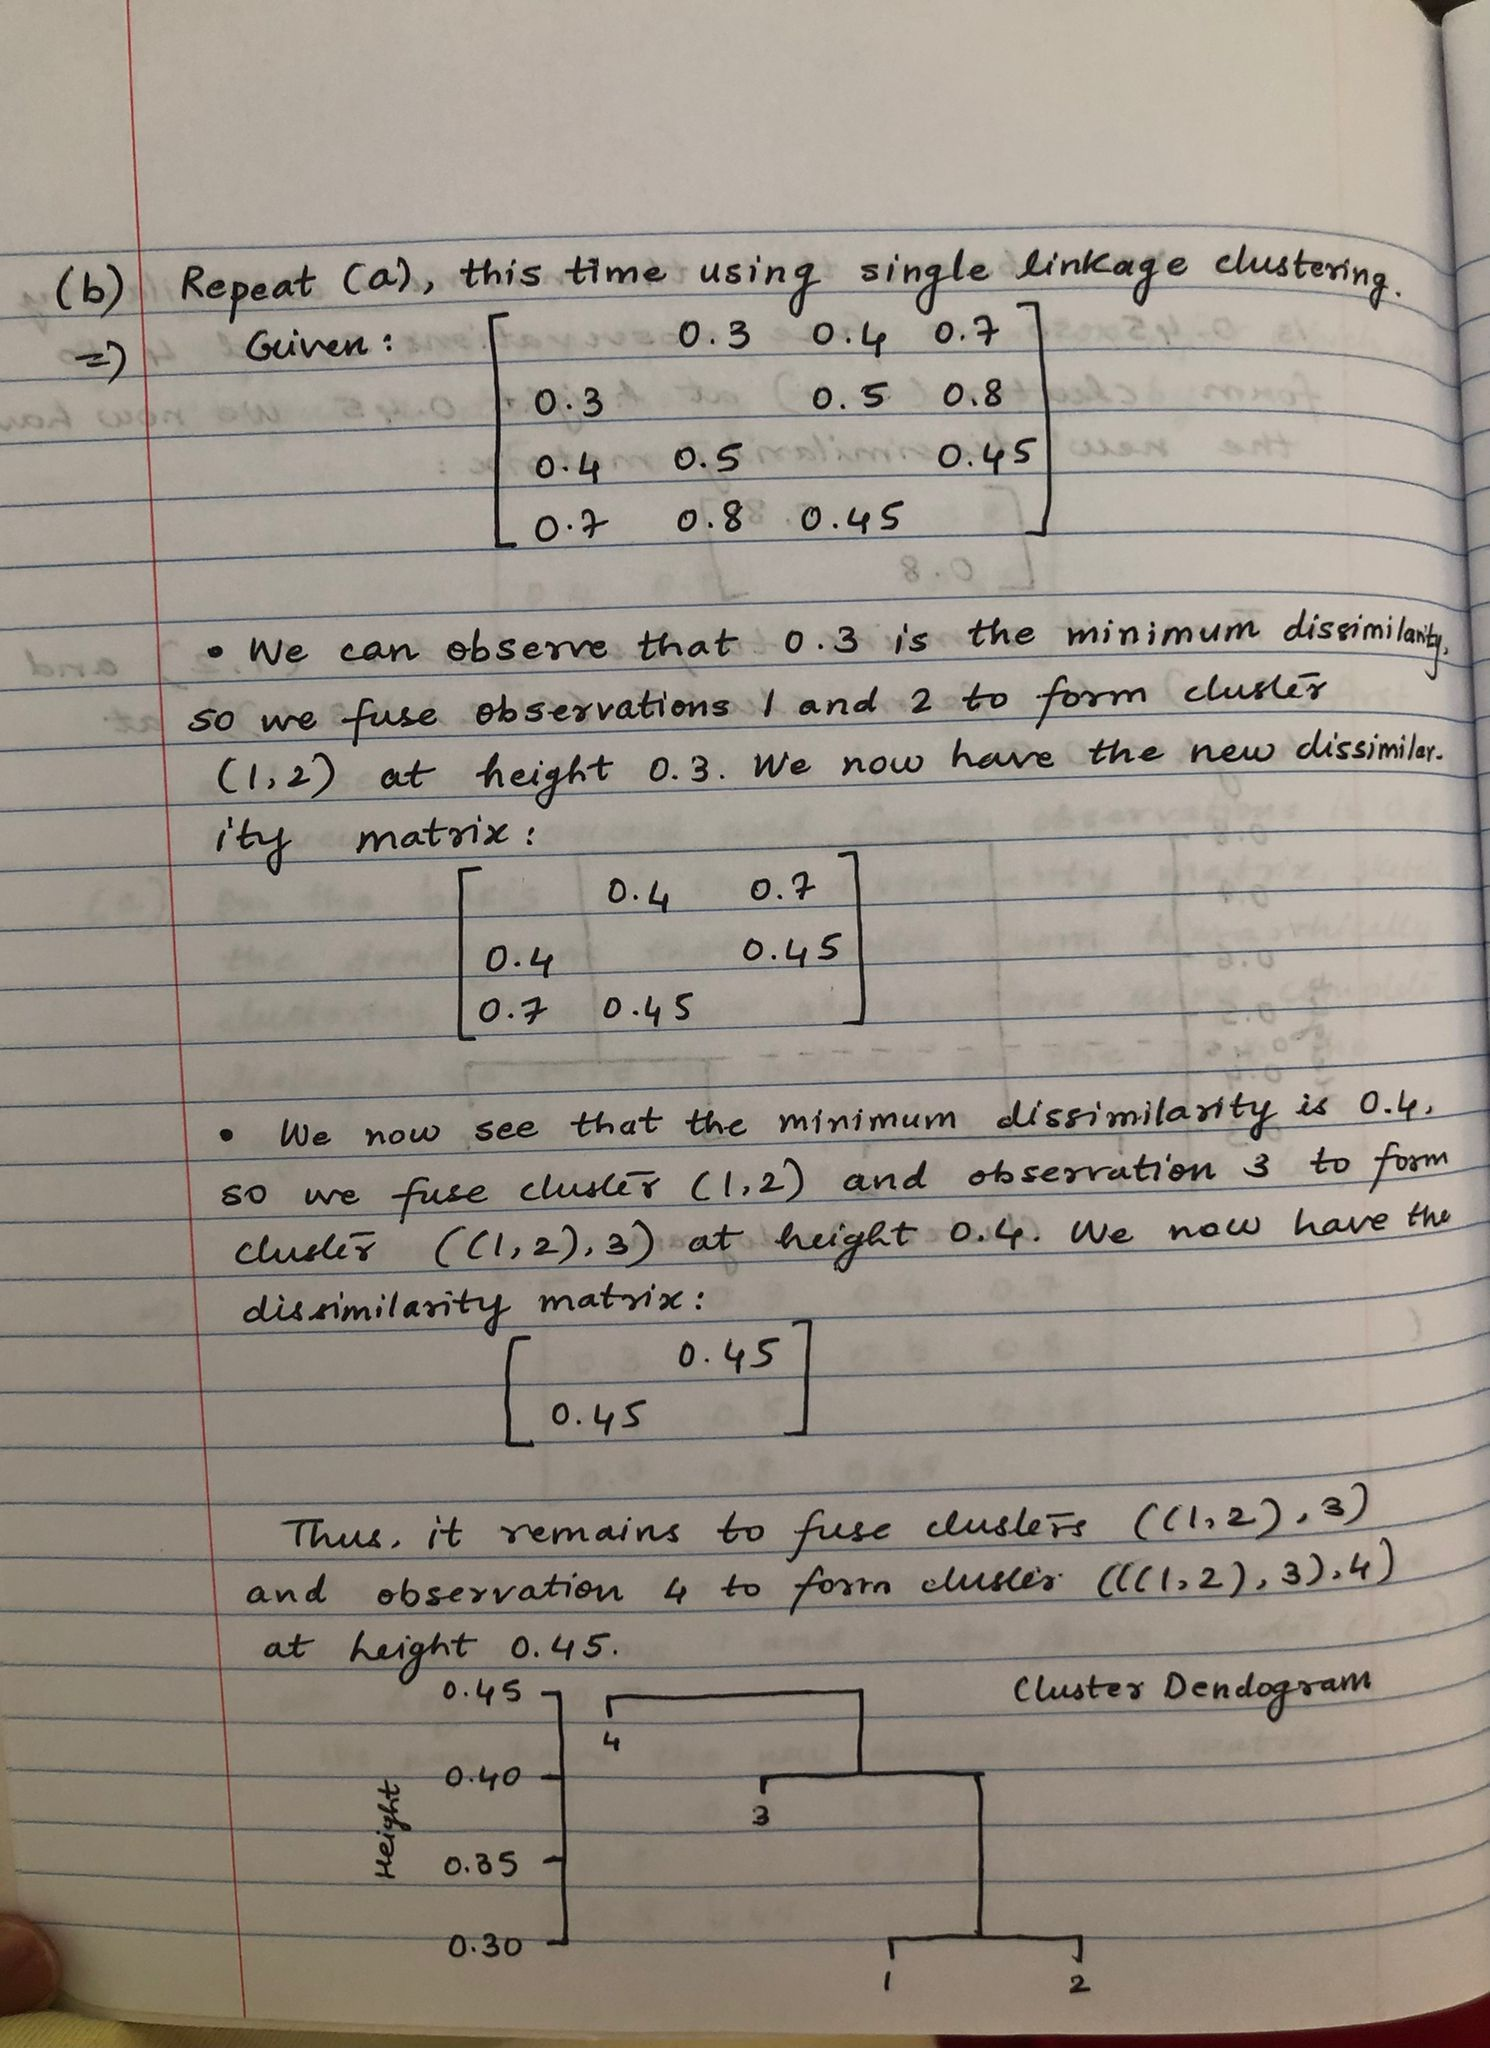

In [102]:
# Qsn (b)
Image('../image/ISLR_10.7.2_3.jpeg')

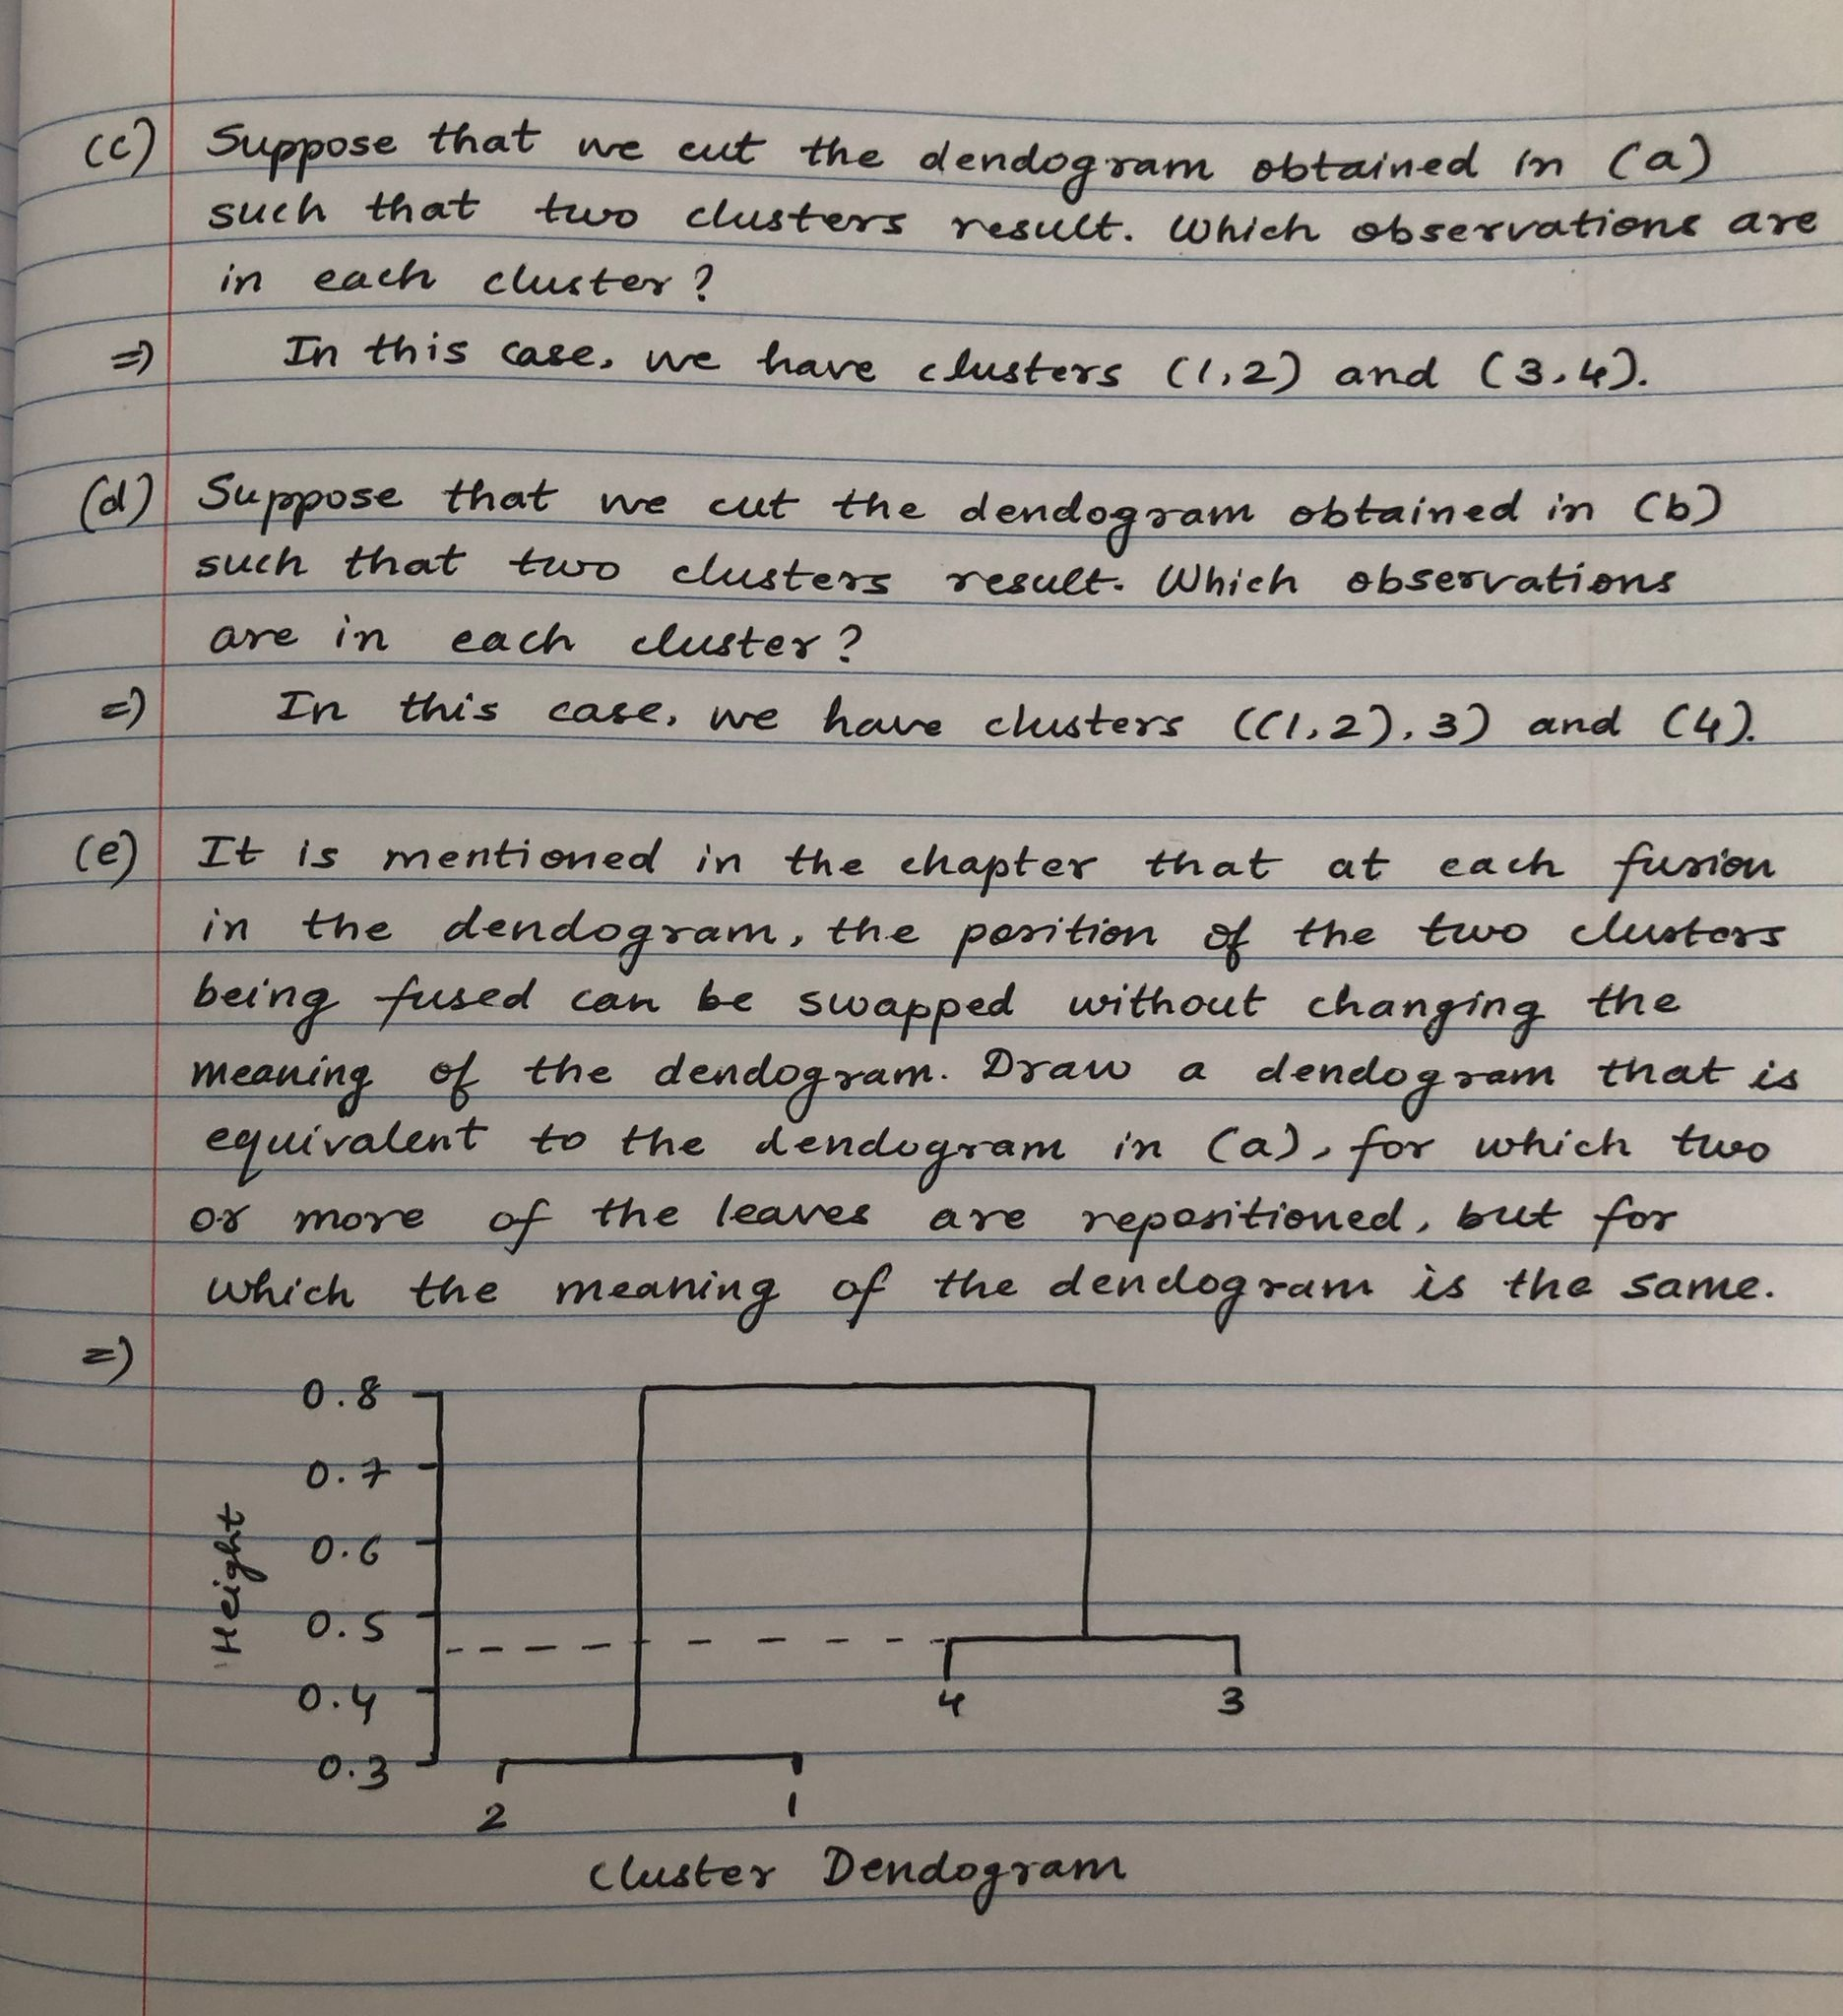

In [103]:
# Qsn (c), (d) and (e)
Image('../image/ISLR_10.7.2_4.jpeg')

# References

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html<br>
https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff<br>
https://medium.com/analytics-vidhya/multi-class-ml-models-evaluation-103c9fdadb41<br>
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html<br>
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html<br>
*A Literature Survey on Algorithms for Multi-label Learning, by Mohammad Sorower*